# 2025-04-16 PETSc experiments

## Last time

* Request RC accounts
* Multigrid - spectral interpretation
  
## Today

* PETSc experiments and projects

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

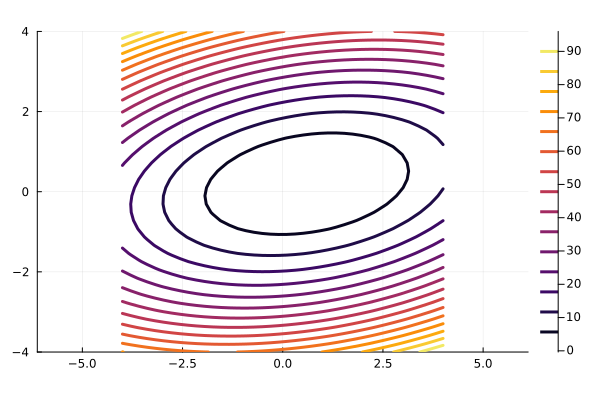

In [2]:
x = LinRange(-4, 4, 40)
A = [2 -1; -1 8]
b = [1, 1] 
f(u) = .5 * u' * A * u - b' * u
contour(x, x, (u1, u2) -> f([u1, u2]), aspect_ratio=:equal)

In [3]:
function grad_descent(loss, grad, u0; omega=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess u0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    u = copy(u0)
    uhist = [copy(u)]
    lhist = [loss(u)]
    for it in 1:500
        g = grad(u)
        u -= omega * g
        push!(uhist, copy(u))
        push!(lhist, loss(u))
        if norm(g) < tol
            break
        end
    end
    (u, hcat(uhist...), lhist)
end

grad_descent (generic function with 1 method)

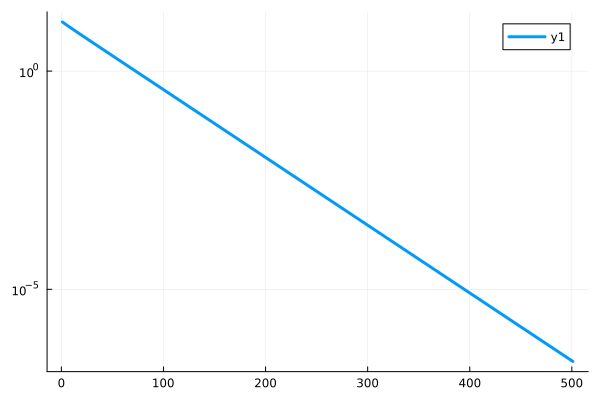

In [4]:
A = [1 1; 1 30]
loss(u) = .5 * u' * A * u
grad(u) = A * u
u, uhist, lhist = grad_descent(loss, grad, [.9, .9],
    omega=.066)
plot(lhist, yscale=:log10)

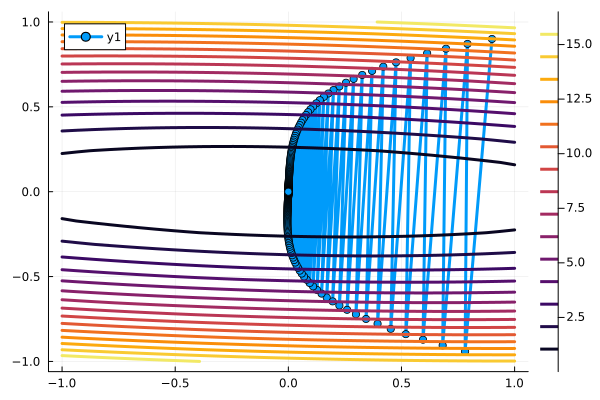

In [5]:
plot(uhist[1, :], uhist[2, :], marker=:circle)
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

# Ill-conditioning

## Question: What is the condition number of the Laplacian on 100 evenly spaced points?

* How does it scale under grid refinement?

In [6]:
A = advdiff_matrix(25)
cond(Matrix(A))

273.3060573767079

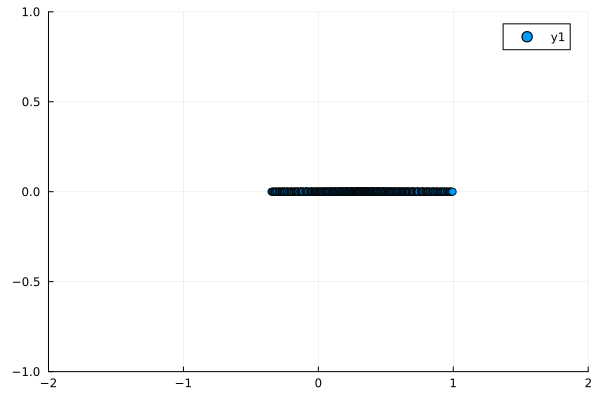

In [7]:
omega = .001
ev = eigvals(Matrix(I - omega * A))
scatter(real.(ev), imag.(ev), xlim=(-2, 2), ylim=(-1, 1))

cond(Matrix(A)) = 48.37415007870825


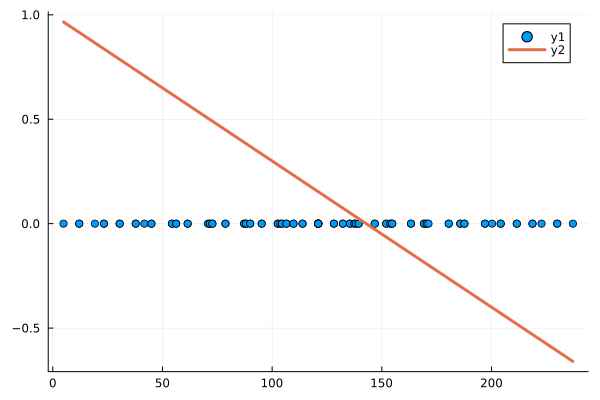

In [8]:
omega = .007
A = advdiff_matrix(10)
@show cond(Matrix(A))
ev = eigvals(Matrix(A))
scatter(real.(ev), zero.(ev))
plot!(x -> (1 - omega * x)^1)

# PETSc notes on GMRES and preconditioners

* PETSc's default solver is GMRES(30) and the restart can be controlled using the run-time option `-ksp_gmres_restart`.
* To use modified (stable) Gram-Schmidt in PETSc: `-ksp_gmres_modifiedgramschmidt`
* Preconditioners:
    * Jacobi preconditioner: `-pc_type jacobi`
    * Gauss-Seidel: `-pc_type sor`
    * `-pc_sor_omega 1`

# Experiments in [PETSc](https://petsc.org)

* PETSc = Portable Extensible Toolkit for Scientific computing
* `./configure`, `make`
  * Depends on BLAS and LAPACK (default system or package manager)
    * or `./configure --download-f2cblaslapack --download-blis`
  * Depends on MPI for parallelism (package manager)
    * or `./configure --download-mpich` (or `--download-openmpi`)
* We'll use `src/snes/tutorials/ex15.c`
  * "p-Bratu": combines p-Laplacian with Bratu nonlinearity
  $$ -\nabla\cdot\big(\kappa(\nabla u) \big) - \lambda e^u = f $$
  * Newton solver with Krylov on each iteration $\to$ **why?**
* SNES: nonlinear solvers library, KSP: linear systems solvers library

# Newton-Krylov methods (+ Jacobian-free)

* Want to solve $F(u) = 0$, where $u$ is a large vector of unknowns and $F$ is a nonlinear, vector-valued function (the residual)
* Newton iteration: $$ F(u^{(k+1)}) \approx F(u^{(k)}) + F'(u^{(k)})\underbrace{(u^{(k+1)} - u^{(k)})}_{\delta u ^{(k)}} $$

$$J(u^{(k)}) \delta u^{(k)} = - F(u^{(k)}), \quad u^{(k+1)} = u^{(k)} + \delta u^{(k)} $$
* In each step, we need to solve a linear system to get  $\delta u^{(k)}$, which is done with a Krylov method

* `docker run -it --rm -v $(pwd):/work registry.gitlab.com/micromorph/ratel`
* From recent clinic: https://github.com/jedbrown/csdms23
* Lots of examples (mostly C and Fortran, some Python)
* Experimental bindings in Rust, Julia

## Run p-Laplacian example
```console
$ cd src/snes/tutorials
$ make ex15
$ ./ex15 -da_refine 2 -dm_view
$ ./ex15 -ksp_monitor -pc_type jacobi
$ ./ex15 -snes_view
```

## Experiments

* 1. 

    * How does iteration count vary under grid refinement?
    * How sensitive is it to parameters
      * p-Laplacian `-p` $> 1$ and `-epsilon` $> 0$
      * Bratu `-lambda` $< 6.8$
    * How sensitive to `-ksp_gmres_restart`?
    * `-ksp_monitor_true_residual`
    * `-ksp_view_eigenvalues`

* 2. 
    * Compare domain decomposition and multigrid preconditioning
     * `-pc_type asm` (Additive Schwarz)
      * `-pc_asm_type basic` (symmetric, versus `restrict`)
      * `-pc_asm_overlap 2` (increase overlap)
      * Effect of direct subdomain solver: `-sub_pc_type lu`
    * Symmetric example: `src/snes/examples/tutorials/ex5.c`
    * Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
    * Compare preconditioned versus unpreconditioned norms.
    * Compare BiCG versus GMRES
     * `-pc_type mg` (Geometric Multigrid)
    * Use monitors:
     * `-ksp_monitor_true_residual`
     * `-ksp_monitor_singular_value`
     * `-ksp_converged_reason`
    * Explain methods: `-snes_view`
    * Performance info: `-log_view`